## Quick analysis of LRG truth table, and the failure modes

In [2]:
import os, sys, glob
import numpy as np

from astropy.io import fits
from astropy.table import Table, join, vstack
from astropy.io import fits

import pandas as pd
import fnmatch

import desispec.io

#import desispec
# library location will change ..
sys.path.append("/global/homes/r/rtojeiro/prospect/prospect/py")
from prospect import utils_specviewer,plotframes
import matplotlib.pyplot as plt 
fs = 15

In [3]:
tiledir   = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/'
tiles = ['68002']
nights = ['20200315']
petals = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']
obs_db = utils_specviewer.make_targetdict(tiledir, petals=petals, tiles=tiles) # tiles = optional 

In [4]:
pd.set_option('display.max_rows', 20)

In [5]:
def display_spectra(targetIDs, show_spectra=None):

    # VI interface in notebook
    if show_spectra:
        spectra, zcat= utils_specviewer.load_spectra_zcat_from_targets(targetIDs, tiledir, obs_db)
        plotframes.plotspectra(spectra, zcatalog=zcat, title='Target_select', notebook=True, mask_type='CMX_TARGET',with_vi_widgets=False)

### Read table

In [6]:
VI_dir = os.environ['HOME']+'/SV/VI_files/SV0/LRG/'

filenames = ['truth_table_LRGs_sets2_10.txt', 'truth_table_LRGs_sets11_20.txt']
merged_full = pd.read_csv(VI_dir+filenames[0])
for i in range(1,len(filenames)):
    merged = pd.read_csv(VI_dir+filenames[i])
    merged_full = merged_full.append(merged, ignore_index=True,sort=False)

full_filename='truth_table_LRG_partial_68002.txt'
merged_full.to_csv(VI_dir + full_filename)

In [7]:
tt = pd.read_csv(VI_dir+full_filename)
tt['dz'] = (tt['Redrock z'] - tt['best redshift'])/(1 + tt['best redshift'])

In [8]:
tt.keys()

Index(['Unnamed: 0', 'TargetID', 'Redrock z', 'Redrock spectype',
       'best redshift', 'best spectype', 'vi_combined_flag', 'N_VI',
       'all VI comments', 'merger comment', 'DELTACHI2', 'FIBER', 'FLUX_G',
       'FLUX_R', 'FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'dz'],
      dtype='object')

In [9]:
len(tt)

950

## Histogram of combined flags
A combined flag is the mean of the flags of all inspectors in the cases where there are no conflicts, or a flag manually set by a merger in case of conflicts.

**We take all objects with a combined flag greater than 2.5 as secure.**

Text(0,0.5,'N')

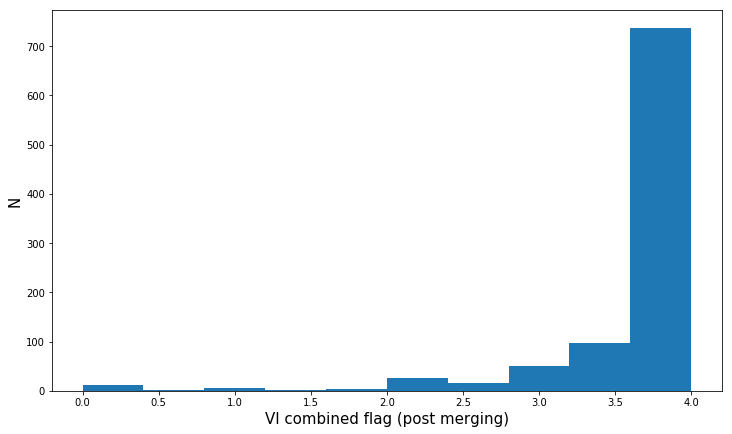

In [10]:
plt.figure(figsize=(12,7))
plt.hist(tt['vi_combined_flag'])
plt.xlabel('VI combined flag (post merging)', fontsize=fs)
plt.ylabel('N', fontsize=fs)

## Redshift distribution

In [26]:
lrgs = tt[(tt['best redshift'] > 0.4) & (tt['best redshift'] < 1.0) & (tt['best spectype']=='GALAXY') ]
good = tt[(tt['vi_combined_flag'] >=2.5) & (tt['best redshift'] > 0.4) & (tt['best redshift'] < 1.0) & (tt['best spectype']=='GALAXY')]
good_z = tt[(tt['vi_combined_flag'] >=2.5)]
print(len(lrgs))
print(len(good))
print(len(good_z))

741
709
900


In [12]:
print('fraction of secure LRG redshifts: ',len(good)/len(lrgs))

fraction of secure LRG redshifts:  0.9562334217506632


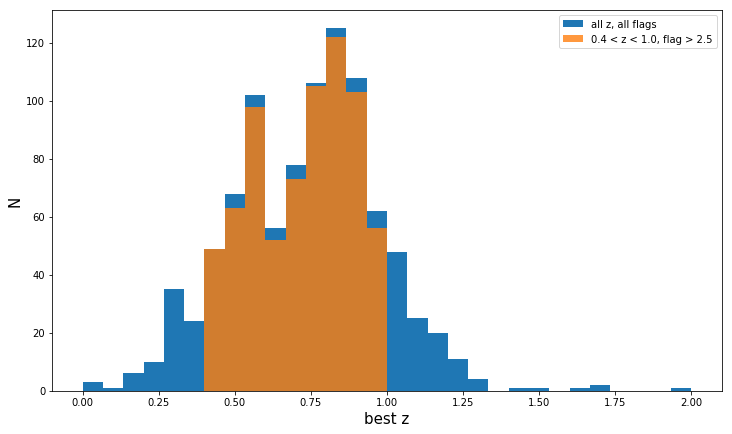

In [13]:
plt.figure(figsize=(12,7))
plt.hist(tt['best redshift'], label='all z, all flags', range=(0,2), bins=30)
plt.hist(good['best redshift'], label = '0.4 < z < 1.0, flag > 2.5', range=(0,2), bins=30, alpha=0.8)
plt.xlabel('best z', fontsize=fs)
plt.ylabel('N', fontsize=fs)
plt.legend()

## Looking at the failures in more detail

We define **secure failures** as objects for which redrock got the wrong redshift, but VI provides a secure redshift.

We define **not secure failures** as objects for which redrock (probably) got the wrong redshift, and for which inspectors attempted an alternative redshift, but with low confidence.

We can then inspect each of these sets in a dedicated prospect window.

(below, we will also look at all spectra with poor VI flags)

Text(0,0.5,'Redrock z')

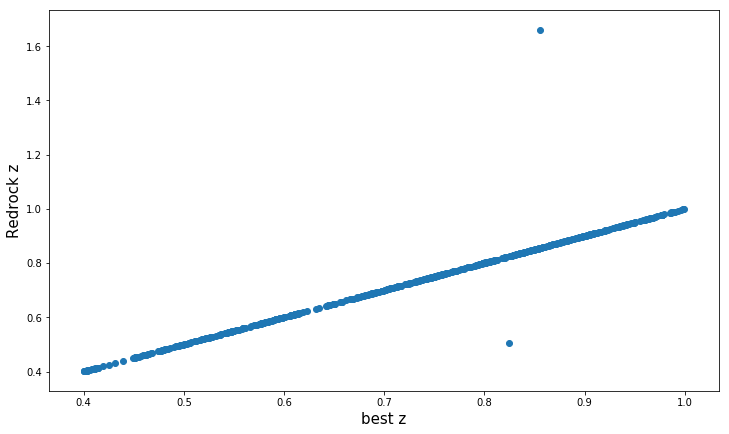

In [14]:
plt.figure(figsize=(12,7))
plt.scatter(good['best redshift'],good['Redrock z'] )
plt.xlabel('best z', fontsize=fs)
plt.ylabel('Redrock z', fontsize=fs)

In [15]:
fail_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['vi_combined_flag']>=2.5)]
print(len(fail_secure))

4


In [16]:
#display_spectra(fail_secure['TargetID'].to_list(), show_spectra=True)

In [17]:
fail_not_secure = tt[(np.abs(tt['dz'])>0.0033) & (tt['vi_combined_flag']<2.5)]
print(len(fail_not_secure))

10


In [18]:
#display_spectra(fail_not_secure['TargetID'].to_list(), show_spectra=True)

## Looking at poor-quality spectra

More generally, we can look at ALL spectra with poor quality flags (for many of these, the redrock z will have been left untouched, and do not qualify as "failures")

In [19]:
not_secure = tt[tt['vi_combined_flag']<2.5]
print(len(not_secure))

50


## Looking at delta_chi2

Text(0,0.5,'normalised distribution')

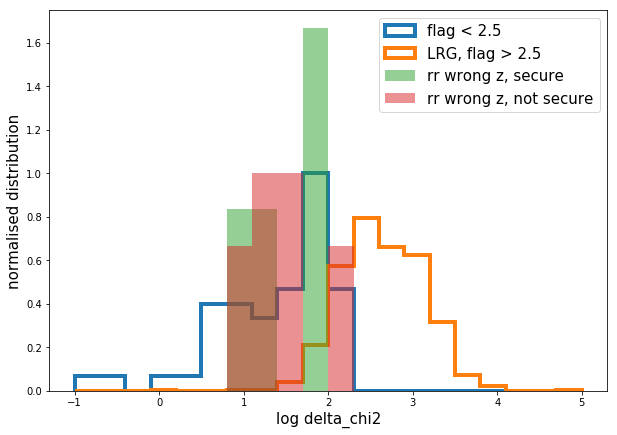

In [25]:
plt.figure(figsize=(10,7))
plt.hist(np.log10(not_secure['DELTACHI2']), label='flag < 2.5', histtype='step', normed=True, lw=4, range=(-1,5), bins=20)
plt.hist(np.log10(good['DELTACHI2']), label='LRG, flag > 2.5', histtype='step', normed=True, lw=4, range=(-1,5), bins=20)
plt.hist(np.log10(fail_secure['DELTACHI2']), label='rr wrong z, secure', alpha=0.5, normed=True, range=(-1,5), bins=20)
plt.hist(np.log10(fail_not_secure['DELTACHI2']), label='rr wrong z, not secure', alpha=0.5, normed=True, range=(-1,5), bins=20)
plt.legend(fontsize=fs)
plt.xlabel('log delta_chi2', fontsize=fs)
plt.ylabel('normalised distribution', fontsize=fs)
